<a href="https://colab.research.google.com/github/Mkhan2317/SPY-Momentum-Alpha-Backtesting-2-Years-of-Free-Polygon-Data-/blob/main/BeatTheMarket_paper_backtesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Paper reference : https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4824172

Intraday momentum strategies seek to capitalize on short-term price trends, exploiting supply and demand imbalances that arise during the trading session. The paper "Beat the Market: An Effective Intraday Momentum Strategy for S&P 500 ETF (SPY)" presents a systematic approach to intraday trend-following, deviating from traditional models that focus on the final minutes of trading. Instead, this strategy initiates positions dynamically in response to abnormal market imbalances, integrating techniques commonly used by active day traders. A key feature of the approach is the use of dynamic trailing stops, which aim to limit downside risk while preserving upside potential.

Inspired by the methodology outlined in the paper, this project implements and backtests the proposed intraday momentum strategy on historical SPY data. The analysis evaluates its profitability, risk-adjusted returns, and robustness across different market conditions, including varying volatility regimes and day-of-the-week effects. Additionally, we assess the impact of execution costs such as commissions and slippage, ensuring a realistic assessment of real-world applicability.

The following code details the full backtesting pipeline, including data preprocessing, strategy implementation, and performance evaluation.





# 0. Needed Functions & Libraries

In [1]:
import requests
import time
import pandas as pd
from   datetime import datetime
import numpy as np
import pytz
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from   matplotlib.ticker import FuncFormatter
import statsmodels.api as sm

In [6]:

# Define the API key and base URL
API_KEY  = 'dFijLeWN9YFkw3fXC0fewEzWWupGZM7W'
BASE_URL = 'https://api.polygon.io'

# Define the rate limit enforcement based on the API tier
ENFORCE_RATE_LIMIT = True

def fetch_polygon_data(ticker, start_date, end_date, period, enforce_rate_limit=ENFORCE_RATE_LIMIT):
    """Fetch stock data from Polygon.io based on the given period (minute or day).
       enforce_rate_limit: Set to True to enforce rate limits (suitable for free tiers), False for paid tiers with minimal or no rate limits.
    """
    multiplier = '1'
    timespan = period
    limit = '50000'  # Maximum entries per request
    eastern = pytz.timezone('America/New_York')  # Eastern Time Zone

    url = f'{BASE_URL}/v2/aggs/ticker/{ticker}/range/{multiplier}/{timespan}/{start_date}/{end_date}?adjusted=false&sort=asc&limit={limit}&apiKey={API_KEY}'

    data_list = []
    request_count = 0
    first_request_time = None

    while True:
        if enforce_rate_limit and request_count == 5:
            elapsed_time = time.time() - first_request_time
            if elapsed_time < 60:
                wait_time = 60 - elapsed_time
                print(f"API rate limit reached. Waiting {wait_time:.2f} seconds before next request.")
                time.sleep(wait_time)
            request_count = 0
            first_request_time = time.time()  # Reset the timer after the wait

        if first_request_time is None and enforce_rate_limit:
            first_request_time = time.time()

        response = requests.get(url)
        if response.status_code != 200:
            error_message = response.json().get('error', 'No specific error message provided')
            print(f"Error fetching data: {error_message}")
            break

        data = response.json()
        request_count += 1

        results_count = len(data.get('results', []))
        print(f"Fetched {results_count} entries from API.")

        if 'results' in data:
            for entry in data['results']:
                utc_time = datetime.fromtimestamp(entry['t'] / 1000, pytz.utc)
                eastern_time = utc_time.astimezone(eastern)

                data_entry = {
                    'volume': entry['v'],
                    'open': entry['o'],
                    'high': entry['h'],
                    'low': entry['l'],
                    'close': entry['c'],
                    'caldt': eastern_time.replace(tzinfo=None)
                }

                if period == 'minute':
                    if eastern_time.time() >= datetime.strptime('09:30', '%H:%M').time() and eastern_time.time() <= datetime.strptime('15:59', '%H:%M').time():
                        data_list.append(data_entry)
                else:
                    data_list.append(data_entry)

        if 'next_url' in data and data['next_url']:
            url = data['next_url'] + '&apiKey=' + API_KEY
        else:
            break

    df = pd.DataFrame(data_list)
    print("Data fetching complete.")
    return df


def fetch_polygon_dividends(ticker):
    """ Fetches dividend data from Polygon.io for a specified stock ticker. """
    url = f'{BASE_URL}/v3/reference/dividends?ticker={ticker}&limit=1000&apiKey={API_KEY}'

    dividends_list = []
    while True:
        response = requests.get(url)
        data = response.json()
        if 'results' in data:
            for entry in data['results']:
                dividends_list.append({
                    'caldt': datetime.strptime(entry['ex_dividend_date'], '%Y-%m-%d'),
                    'dividend': entry['cash_amount']
                })

        if 'next_url' in data and data['next_url']:
            url = data['next_url'] + '&apiKey=' + API_KEY
        else:
            break

    return pd.DataFrame(dividends_list)

# 1. Download Data

In [7]:
ticker      = 'SPY'
from_date   = '2022-05-09'
until_date  = '2024-04-22'

spy_intra_data = fetch_polygon_data(ticker, from_date, until_date, 'minute')
spy_daily_data = fetch_polygon_data(ticker, from_date, until_date, 'day')
dividends      = fetch_polygon_dividends(ticker)


Fetched 50000 entries from API.
Fetched 50000 entries from API.
Fetched 50000 entries from API.
Fetched 50000 entries from API.
Fetched 37100 entries from API.
Data fetching complete.
Fetched 295 entries from API.
Data fetching complete.


# 2. Add Key Variables

In [8]:
# Load the intraday data into a DataFrame and set the datetime column as the index.
df = pd.DataFrame(spy_intra_data)
df['day'] = pd.to_datetime(df['caldt']).dt.date  # Extract the date part from the datetime for daily analysis.
df.set_index('caldt', inplace=True)  # Setting the datetime as the index for easier time series manipulation.

# Group the DataFrame by the 'day' column to facilitate operations that need daily aggregation.
daily_groups = df.groupby('day')

# Extract unique days from the dataset to iterate through each day for processing.
all_days = df['day'].unique()

# Initialize new columns to store calculated metrics, starting with NaN for absence of initial values.
df['move_open'] = np.nan  # To record the absolute daily change from the open price
df['vwap'] = np.nan       # To calculate the Volume Weighted Average Price.
df['spy_dvol'] = np.nan   # To record SPY's daily volatility.

# Create a series to hold computed daily returns for SPY, initialized with NaN.
spy_ret = pd.Series(index=all_days, dtype=float)

# Iterate through each day to calculate metrics.
for d in range(1, len(all_days)):
    current_day = all_days[d]
    prev_day = all_days[d - 1]

    # Access the data for the current and previous days using their groups.
    current_day_data = daily_groups.get_group(current_day)
    prev_day_data = daily_groups.get_group(prev_day)

    # Calculate the average of high, low, and close prices.
    hlc = (current_day_data['high'] + current_day_data['low'] + current_day_data['close']) / 3

    # Compute volume-weighted metrics for VWAP calculation.
    vol_x_hlc = current_day_data['volume'] * hlc
    cum_vol_x_hlc = vol_x_hlc.cumsum()  # Cumulative sum for VWAP calculation.
    cum_volume = current_day_data['volume'].cumsum()

    # Assign the calculated VWAP to the corresponding index in the DataFrame.
    df.loc[current_day_data.index, 'vwap'] = cum_vol_x_hlc / cum_volume

    # Calculate the absolute percentage change from the day's opening price.
    open_price = current_day_data['open'].iloc[0]
    df.loc[current_day_data.index, 'move_open'] = (current_day_data['close'] / open_price - 1).abs()

    # Compute the daily return for SPY using the closing prices from the current and previous day.
    spy_ret.loc[current_day] = current_day_data['close'].iloc[-1] / prev_day_data['close'].iloc[-1] - 1

    # Calculate the 15-day rolling volatility, starting calculation after accumulating 15 days of data.
    if d > 14:
        df.loc[current_day_data.index, 'spy_dvol'] = spy_ret.iloc[d - 15:d - 1].std(skipna=False)

# Calculate the minutes from market open and determine the minute of the day for each timestamp.
df['min_from_open'] = ((df.index - df.index.normalize()) / pd.Timedelta(minutes=1)) - (9 * 60 + 30) + 1
df['minute_of_day'] = df['min_from_open'].round().astype(int)

# Group data by 'minute_of_day' for minute-level calculations.
minute_groups = df.groupby('minute_of_day')

# Calculate rolling mean and delayed sigma for each minute of the trading day.
df['move_open_rolling_mean'] = minute_groups['move_open'].transform(lambda x: x.rolling(window=14, min_periods=13).mean())
df['sigma_open'] = minute_groups['move_open_rolling_mean'].transform(lambda x: x.shift(1))

# Convert dividend dates to datetime and merge dividend data based on trading days.
dividends['day'] = pd.to_datetime(dividends['caldt']).dt.date
df = df.merge(dividends[['day', 'dividend']], on='day', how='left')
df['dividend'] = df['dividend'].fillna(0)  # Fill missing dividend data with 0.


# 3. Backtest

In [9]:

# Constants and settings
AUM_0 = 100000.0
commission = 0.0035
min_comm_per_order = 0.35
band_mult = 1
band_simplified = 0
trade_freq = 30
sizing_type = "vol_target"
target_vol = 0.02
max_leverage = 4


# Group data by day for faster access
daily_groups = df.groupby('day')

# Initialize strategy DataFrame using unique days
strat = pd.DataFrame(index=all_days)
strat['ret'] = np.nan
strat['AUM'] = AUM_0
strat['ret_spy'] = np.nan

# Calculate daily returns for SPY using the closing prices
df_daily = pd.DataFrame(spy_daily_data)
df_daily['caldt'] = pd.to_datetime(df_daily['caldt']).dt.date
df_daily.set_index('caldt', inplace=True)  # Set the datetime column as the DataFrame index for easy time series manipulation.

df_daily['ret'] = df_daily['close'].diff() / df_daily['close'].shift()


# Loop through all days, starting from the second day
for d in range(1, len(all_days)):
    current_day = all_days[d]
    prev_day = all_days[d-1]

    if prev_day in daily_groups.groups and current_day in daily_groups.groups:
        prev_day_data = daily_groups.get_group(prev_day)
        current_day_data = daily_groups.get_group(current_day)

        if 'sigma_open' in current_day_data.columns and current_day_data['sigma_open'].isna().all():
            continue

        prev_close_adjusted = prev_day_data['close'].iloc[-1] - df.loc[current_day_data.index, 'dividend'].iloc[-1]

        open_price = current_day_data['open'].iloc[0]
        current_close_prices = current_day_data['close']
        spx_vol = current_day_data['spy_dvol'].iloc[0]
        vwap = current_day_data['vwap']

        sigma_open = current_day_data['sigma_open']
        UB = max(open_price, prev_close_adjusted) * (1 + band_mult * sigma_open)
        LB = min(open_price, prev_close_adjusted) * (1 - band_mult * sigma_open)

        # Determine trading signals
        signals = np.zeros_like(current_close_prices)
        signals[(current_close_prices > UB) & (current_close_prices > vwap)] = 1
        signals[(current_close_prices < LB) & (current_close_prices < vwap)] = -1


        # Position sizing
        previous_aum = strat.loc[prev_day, 'AUM']

        if sizing_type == "vol_target":
            if math.isnan(spx_vol):
                shares = round(previous_aum / open_price * max_leverage)
            else:
                shares = round(previous_aum / open_price * min(target_vol / spx_vol, max_leverage))

        elif sizing_type == "full_notional":
            shares = round(previous_aum / open_price)

        # Apply trading signals at trade frequencies
        trade_indices = np.where(current_day_data["min_from_open"] % trade_freq == 0)[0]
        exposure = np.full(len(current_day_data), np.nan)  # Start with NaNs
        exposure[trade_indices] = signals[trade_indices]  # Apply signals at trade times

        # Custom forward-fill that stops at zeros
        last_valid = np.nan  # Initialize last valid value as NaN
        filled_values = []   # List to hold the forward-filled values
        for value in exposure:
            if not np.isnan(value):  # If current value is not NaN, update last valid value
                last_valid = value
            if last_valid == 0:  # Reset if last valid value is zero
                last_valid = np.nan
            filled_values.append(last_valid)

        exposure = pd.Series(filled_values, index=current_day_data.index).shift(1).fillna(0).values  # Apply shift and fill NaNs

        # Calculate trades count based on changes in exposure
        trades_count = np.sum(np.abs(np.diff(np.append(exposure, 0))))

        # Calculate PnL
        change_1m = current_close_prices.diff()
        gross_pnl = np.sum(exposure * change_1m) * shares
        commission_paid = trades_count * max(min_comm_per_order, commission * shares)
        net_pnl = gross_pnl - commission_paid

        # Update the daily return and new AUM
        strat.loc[current_day, 'AUM'] = previous_aum + net_pnl
        strat.loc[current_day, 'ret'] = net_pnl / previous_aum

        # Save the passive Buy&Hold daily return for SPY
        strat.loc[current_day, 'ret_spy'] = df_daily.loc[df_daily.index == current_day, 'ret'].values[0]



# 4. Study Results

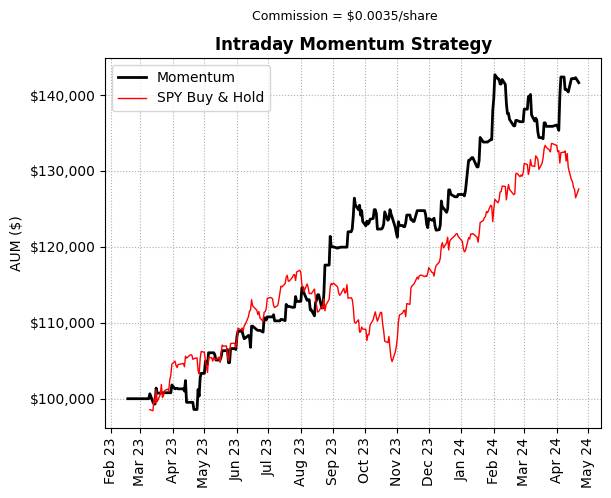

{'Total Return (%)': 42.0, 'Annualized Return (%)': 34.6, 'Annualized Volatility (%)': 13.6, 'Sharpe Ratio': 2.36, 'Hit Ratio (%)': 50.0, 'Maximum Drawdown (%)': 6.0, 'Alpha (%)': 29.55, 'Beta': 0.11}


In [10]:
# Calculate cumulative products for AUM calculations
strat['AUM_SPX'] = AUM_0 * (1 + strat['ret_spy']).cumprod(skipna=True)

# Create a figure and a set of subplots
fig, ax = plt.subplots()

# Plotting the AUM of the strategy and the passive S&P 500 exposure
ax.plot(strat.index, strat['AUM'], label='Momentum', linewidth=2, color='k')
ax.plot(strat.index, strat['AUM_SPX'], label=f'{ticker} Buy & Hold', linewidth=1, color='r')

# Formatting the plot
ax.grid(True, linestyle=':')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))
plt.xticks(rotation=90)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'${x:,.0f}'))
ax.set_ylabel('AUM ($)')
plt.legend(loc='upper left')
plt.title('Intraday Momentum Strategy', fontsize=12, fontweight='bold')
plt.suptitle(f'Commission = ${commission}/share', fontsize=9, verticalalignment='top')

# Show the plot
plt.show()

# Calculate additional stats and display them
stats = {
    'Total Return (%)': round((np.prod(1 + strat['ret'].dropna()) - 1) * 100, 0),
    'Annualized Return (%)': round((np.prod(1 + strat['ret']) ** (252 / len(strat['ret'])) - 1) * 100, 1),
    'Annualized Volatility (%)': round(strat['ret'].dropna().std() * np.sqrt(252) * 100, 1),
    'Sharpe Ratio': round(strat['ret'].dropna().mean() / strat['ret'].dropna().std() * np.sqrt(252), 2),
    'Hit Ratio (%)': round((strat['ret'] > 0).sum() / (strat['ret'].abs() > 0).sum() * 100, 0),
    'Maximum Drawdown (%)': round(strat['AUM'].div(strat['AUM'].cummax()).sub(1).min() * -100, 0)
}


Y = strat['ret'].dropna()
X = sm.add_constant(strat['ret_spy'].dropna())
model = sm.OLS(Y, X).fit()
stats['Alpha (%)'] = round(model.params.const * 100 * 252, 2)
stats['Beta'] = round(model.params['ret_spy'], 2)

print(stats)
